In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import os
import sys
import holidays


import sklearn
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [3]:
test.head()

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [4]:
df = pd.concat([train, test], ignore_index=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.rename({"price(원/kg)":"price", "supply(kg)":"supply"}, axis=1, inplace=True)

df['timestamp'].dt.year

0        2019
1        2019
2        2019
3        2019
4        2019
         ... 
60484    2023
60485    2023
60486    2023
60487    2023
60488    2023
Name: timestamp, Length: 60489, dtype: int32

In [34]:
def pre_all(train, test):
    print(f"전처리 전 train 크기: {train.shape}")
    print(f"전처리 전 test 크기: {test.shape}")
    print("=======now preprocessing=======")

    df = pd.concat([train, test], ignore_index=True)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.rename({"price(원/kg)":"price", "supply(kg)":"supply"}, axis=1, inplace=True)
    
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['week_day'] = df['timestamp'].dt.weekday
    df['year_month'] = df['timestamp'].map(lambda x: str(x.year)+"-"+str(x.month))

    le = LabelEncoder()
    df['year_month'] = le.fit_transform(df['year_month'])
    df['week'] = df['timestamp'].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])
    
    week_list=[]
    for i in range(len(df['year'])) :
        if df['year'][i] == 2019 :
            week_list.append(int(df['week'][i]))
        elif df['year'][i] == 2020 :
            week_list.append(int(df['week'][i])+52)
        elif df['year'][i] == 2021 :
            week_list.append(int(df['week'][i])+52+53)
        elif df['year'][i] == 2022 :
            week_list.append(int(df['week'][i])+52+53+53)
        elif df['year'][i] == 2023 :
            week_list.append(int(df['week'][i])+52+53+53+52)
    df['week_num']= week_list

    # datetime 패키지에서 19년 12월 마지막주가 첫째주로 들어가는거 발견하여 수정
    df.loc[df['timestamp']=='2019-12-30','week_num']=52
    df.loc[df['timestamp']=='2019-12-31','week_num']=52

    def make_hol(x):
        holi = holidays.KR()
        if x.weekday() in range(5,7):
            return 1
        elif x in holi:
            return 1
        else:
            return 0 
        
    df['holiday'] = df['timestamp'].apply(make_hol)

    train = df.iloc[:train.shape[0],:].reset_index(drop=True)
    test = df.iloc[train.shape[0]:,:].reset_index(drop=True)
    print(f"전처리 후 train 크기 : {train.shape}")
    print(f"전처리 후 test 크기 : {test.shape}")

    return train, test


In [35]:
train_pre, test_pre = pre_all(train, test)

전처리 전 train 크기: (59397, 7)
전처리 전 test 크기: (1092, 5)
=======now preprocessing=======
전처리 후 train 크기 : (59397, 15)
전처리 후 test 크기 : (1092, 15)


In [51]:
train_pre[(train_pre['price']>=10000)&(train_pre['item']=='TG')]

,ID,timestamp,item,corporation,location,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
492,TG_A_J_20200507,2020-05-07,TG,A,J,37.5,10000.0,2020,5,7,3,19,19,71,0
597,TG_A_J_20200820,2020-08-20,TG,A,J,156.0,10122.0,2020,8,20,3,22,34,86,0
611,TG_A_J_20200903,2020-09-03,TG,A,J,12.0,11333.0,2020,9,3,3,23,36,88,0
850,TG_A_J_20210430,2021-04-30,TG,A,J,162.0,11704.0,2021,4,30,4,30,17,122,0
851,TG_A_J_20210501,2021-05-01,TG,A,J,363.0,10733.0,2021,5,1,5,31,17,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14561,TG_E_S_20210504,2021-05-04,TG,E,S,165.0,11818.0,2021,5,4,1,31,18,123,0
14563,TG_E_S_20210506,2021-05-06,TG,E,S,126.0,11333.0,2021,5,6,3,31,18,123,0
14568,TG_E_S_20210511,2021-05-11,TG,E,S,75.0,10760.0,2021,5,11,1,31,19,124,0
14569,TG_E_S_20210512,2021-05-12,TG,E,S,150.0,10333.0,2021,5,12,2,31,19,124,0


In [65]:
def inter_outliers(df, columns):
    new_df = df.copy()
    items = new_df['item'].unique()

    for col in columns:
        for item in items:
            q1 = new_df[new_df['item']==item][col].quantile(0.25)
            q3 = new_df[new_df['item']==item][col].quantile(0.75)

            iqr = q3-q1

            upper = q3 + 1.5*iqr
            lower = max(q1 - 1.5*iqr,0.1)

            print(f"upper bound of {col} / {item} is {upper}")
            print(f"lower bound of {col} / {item} is {lower}")

            idx = new_df[(new_df[col]>=upper)&(new_df['item']==item)].index
            new_df.loc[idx,'price'] = new_df[(new_df['item']==item)&(new_df['price']!=0)]['price'].mean()
    return new_df

train_pre_ = inter_outliers(train_pre, ['supply','price'])

upper bound of supply / TG is 42236.25
lower bound of supply / TG is 0.1
upper bound of supply / CR is 0.0
lower bound of supply / CR is 0.1
upper bound of supply / CB is 0.0
lower bound of supply / CB is 0.1
upper bound of supply / RD is 20937.5
lower bound of supply / RD is 0.1
upper bound of supply / BC is 1240.0
lower bound of supply / BC is 0.1
upper bound of price / TG is 12336.375
lower bound of price / TG is 0.1
upper bound of price / CR is 1398.5211335254562
lower bound of price / CR is 1398.5211335254562
upper bound of price / CB is 715.3734567901234
lower bound of price / CB is 715.3734567901234
upper bound of price / RD is 1182.5
lower bound of price / RD is 0.1
upper bound of price / BC is 6892.853591160221
lower bound of price / BC is 0.1


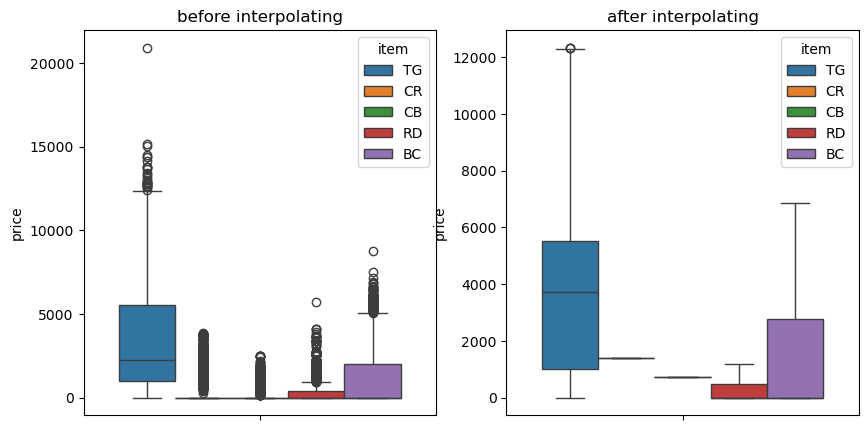

In [66]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(data=train_pre, y="price", hue='item')
plt.title("before interpolating")

plt.subplot(1,2,2)
sns.boxplot(data=train_pre_, y="price", hue='item')
plt.title("after interpolating")

plt.show()

In [68]:
train_notg = train_pre_[train_pre_['item']!="TG"]
test_notg = test_pre[test_pre['item']!="TG"]


In [71]:
Xy = pd.get_dummies(train_notg.sort_values(by = ["timestamp"]).reset_index(drop=True).drop(columns = ["supply"]), columns = ["item","corporation","location"])
answer_notg = pd.get_dummies(test_notg.drop(columns = ["timestamp","supply","price"]), columns = [ "item","corporation","location"])

In [73]:
cat = CatBoostRegressor(random_state=42,
                        n_estimators=1000,
                        learning_rate=0.01,
                        depth=10,
                        l2_leaf_reg=3,
                        metric_period=1000)

xgb = XGBRegressor(n_estimators=1000,
                   random_state=42,
                   learning_rate=0.01,
                   max_depth=10)

vote_model = VotingRegressor(estimators=[("cat",cat),
                                         ("xgb",xgb)])

vote_model.fit(Xy.drop(["timestamp","ID","price"],axis=1), Xy["price"])
pred = vote_model.predict(answer_notg.drop(['ID'],axis=1))



0:	learn: 894.8733336	total: 76.4ms	remaining: 1m 16s
999:	learn: 317.7420087	total: 7.29s	remaining: 0us


In [74]:
for idx in range(len(pred)):
    if pred[idx]<0:
        pred[idx]=0

answer_notg['answer']=pred
answer_notg[["ID","answer"]]

,ID,answer
280,CR_A_J_20230304,1400.230591
281,CR_A_J_20230305,1392.361502
282,CR_A_J_20230306,1408.327591
283,CR_A_J_20230307,1404.709413
284,CR_A_J_20230308,1402.223771
...,...,...
1087,RD_F_J_20230327,550.683168
1088,RD_F_J_20230328,552.796662
1089,RD_F_J_20230329,555.590257
1090,RD_F_J_20230330,549.224329
